In [ ]:
# Environment: Apple M1 Max, macOS 15.0, Python 3.10
!pip install imageio
!pip install ipython
!pip install matplotlib
!pip install opencv-python
!pip install tensorflow
!pip install tensorflow-docs
!pip install tensorflow-hub
!pip install tensorflow-metal

In [1]:
import os
import time

import cv2
# Some modules to display an animation using imageio
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
# Import matplotlib libraries
from matplotlib import pyplot as plt
from tensorflow.python.framework.ops import EagerTensor

2024-10-13 16:13:43.973374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 16:13:44.020957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 16:13:44.041059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 16:13:44.120892: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 16:13:45.416716: W tensorflow/compiler/tf2

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1728807234.587492   34679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728807234.849360   34679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728807234.849420   34679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


In [10]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

color_map = {
    'c': (0, 191, 191),
    'm': (191, 0, 191),
    'y': (191, 191, 0)
}


def save_image_with_prediction(idx,
                               raw_image,
                               keypoints_with_scores,
                               keypoint_threshold=0.11):
    raw_image = raw_image.numpy()
    keypoints_with_scores = keypoints_with_scores.copy()

    raw_height, raw_width, _ = raw_image.shape
    longest_side = max(raw_height, raw_width)

    # Convert relative coordinates to actual coordinates
    keypoints_with_scores[..., :2] *= longest_side

    # Offset the coordinates based on the aspect ratio
    if raw_height > raw_width:
        keypoints_with_scores[..., 1] -= (longest_side - raw_width) // 2
    elif raw_height < raw_width:
        keypoints_with_scores[..., 0] -= (longest_side - raw_height) // 2

    # Retrieve values from the output
    kpts_x = keypoints_with_scores[0, 0, :, 1].astype(int)
    kpts_y = keypoints_with_scores[0, 0, :, 0].astype(int)
    kpts_scores = keypoints_with_scores[0, 0, :, 2]

    # Pair up keypoints to form edges
    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
        if (kpts_scores[edge_pair[0]] > keypoint_threshold and
                kpts_scores[edge_pair[1]] > keypoint_threshold):
            x_start = kpts_x[edge_pair[0]]
            y_start = kpts_y[edge_pair[0]]
            x_end = kpts_x[edge_pair[1]]
            y_end = kpts_y[edge_pair[1]]

            cv2.line(raw_image, [x_start, y_start], [x_end, y_end], color_map[color], thickness=max(longest_side // 300, 1))

    # Plot the keypoints
    for i, coord in enumerate(zip(kpts_x, kpts_y)):
        if kpts_scores[i] > keypoint_threshold:
            cv2.circle(raw_image, coord, radius=max(longest_side // 150, 2), color=(255, 20, 147), thickness=-1)

    # Convert RGB to BGR
    bgr_image = cv2.cvtColor(raw_image, cv2.COLOR_RGB2BGR)

    # Save the image
    cv2.imwrite(f"./output/{idx:08d}.png", bgr_image)

    return f"./output/{idx:08d}.png"

In [4]:
model_name = "movenet_lightning"  #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
    if "movenet_lightning_f16" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
        input_size = 192
    elif "movenet_thunder_f16" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
        input_size = 256
    elif "movenet_lightning_int8" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
        input_size = 192
    elif "movenet_thunder_int8" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path="model.tflite")
    interpreter.allocate_tensors()


    def movenet(input_image):
        """Runs detection on an input image.

        Args:
          input_image: A [1, height, width, 3] tensor represents the input image
            pixels. Note that the height/width should already be resized and match the
            expected input resolution of the model before passing into this function.

        Returns:
          A [1, 1, 17, 3] float numpy array representing the predicted keypoint
          coordinates and scores.
        """
        # TF Lite format expects tensor type of uint8.
        input_image = tf.cast(input_image, dtype=tf.uint8)
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
        # Invoke inference.
        interpreter.invoke()
        # Get the model prediction.
        keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
        return keypoints_with_scores

else:
    if "movenet_lightning" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
        input_size = 192
    elif "movenet_thunder" in model_name:
        module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)


    def movenet(input_image):
        """Runs detection on an input image.

        Args:
          input_image: A [1, height, width, 3] tensor represents the input image
            pixels. Note that the height/width should already be resized and match the
            expected input resolution of the model before passing into this function.

        Returns:
          A [1, 1, 17, 3] float numpy array representing the predicted keypoint
          coordinates and scores.
        """
        model = module.signatures['serving_default']

        # SavedModel format expects tensor type of int32.
        input_image = tf.cast(input_image, dtype=tf.int32)
        # Run model inference.
        outputs = model(input_image)
        # Output is a [1, 1, 17, 3] tensor.
        keypoints_with_scores = outputs['output_0'].numpy()
        return keypoints_with_scores

I0000 00:00:1728807237.453401   34679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728807237.453488   34679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728807237.453525   34679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728807237.880479   34679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728807237.887548   34679 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13

In [5]:
dataset_root_dir = "./dataset"
raw_images: list[EagerTensor] = []  # Each entry is a 3-channel RGB images [0, 255]
for dirpath, dirnames, filenames in os.walk(dataset_root_dir):
    dirnames.sort()
    filenames.sort()

    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        file_extension = os.path.splitext(filepath)[1].lower()

        image = tf.io.read_file(filepath)
        if file_extension in ('.jpg', '.jpeg'):
            image = tf.image.decode_jpeg(image)
        elif file_extension == '.png':
            image = tf.image.decode_png(image)
        else:
            continue

        # Ensure image is 3-channel
        image = image[..., :3]
        raw_images.append(image)

In [6]:
def run_inference(image: EagerTensor) -> np.ndarray:
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)  # (1, 1, 17, 3)

    return keypoints_with_scores

In [7]:
start_time = time.time()
results = [run_inference(raw_image) for raw_image in raw_images]
end_time = time.time()

print("Total time spent:", end_time - start_time)

2024-10-13 16:14:16.856129: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1728807257.034384   34884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728807257.073022   34884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728807257.091924   34884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728807257.108452   34884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728807257.126609   34884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728807257.159354   34884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728807257.172429   34884 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728807257.191067   34884 gpu_t

Total time spent: 21.54635715484619


In [8]:
def show_and_save(image_idx):
    output_path = save_image_with_prediction(image_idx,
                                             raw_images[image_idx],
                                             results[image_idx],
                                             keypoint_threshold=0)

    image = Image.open(output_path)

    # Display the resultant image using Matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    # plt.show()

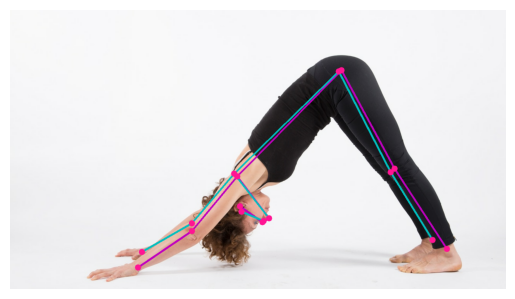

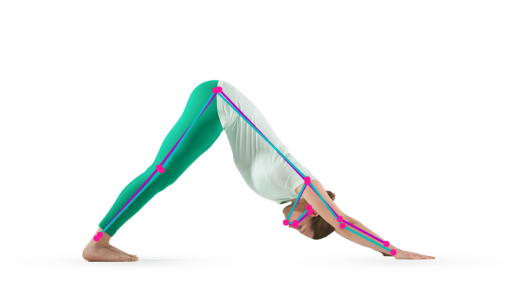

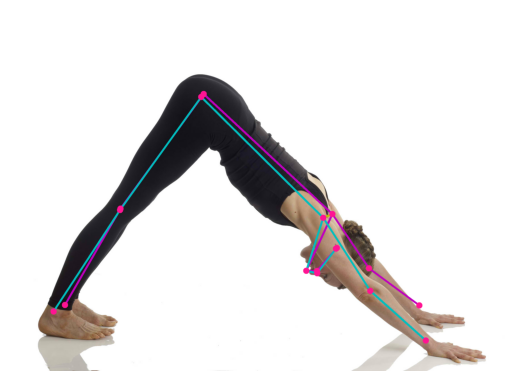

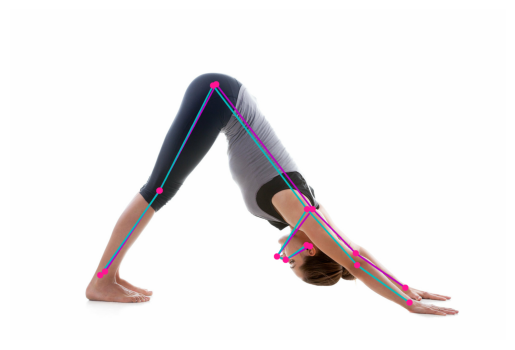

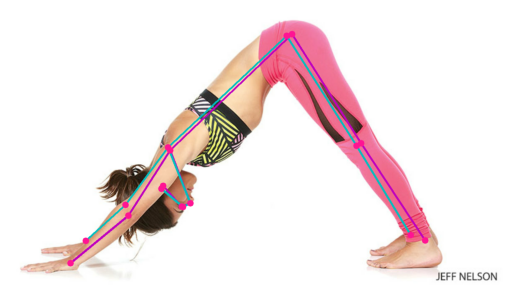

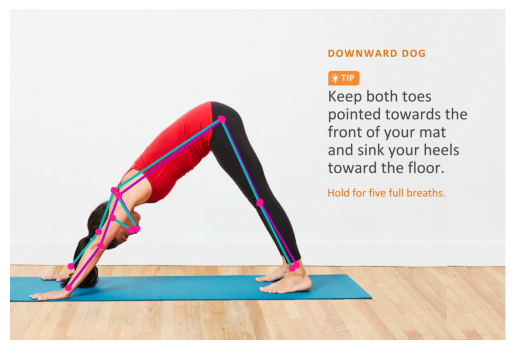

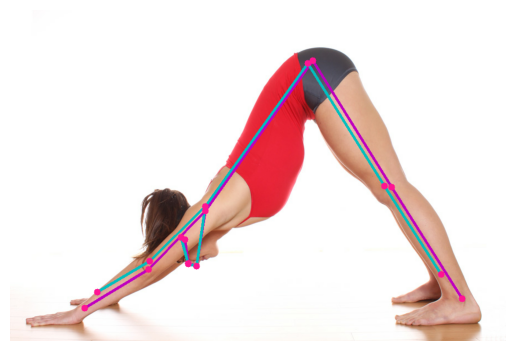

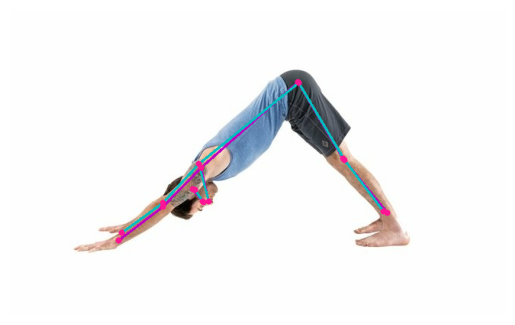

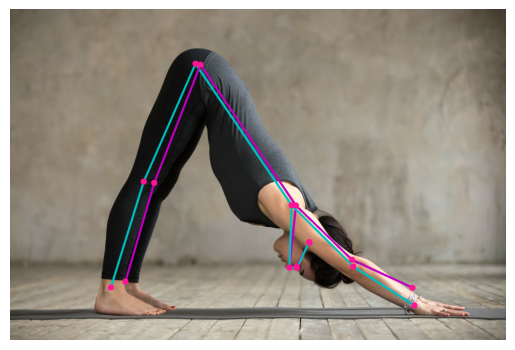

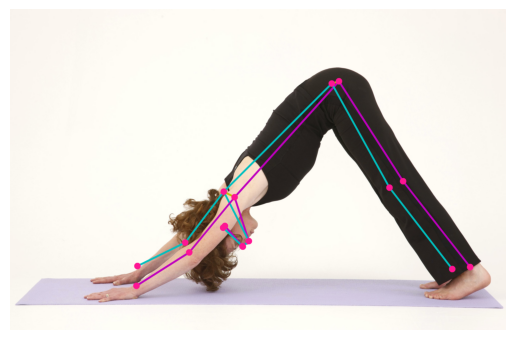

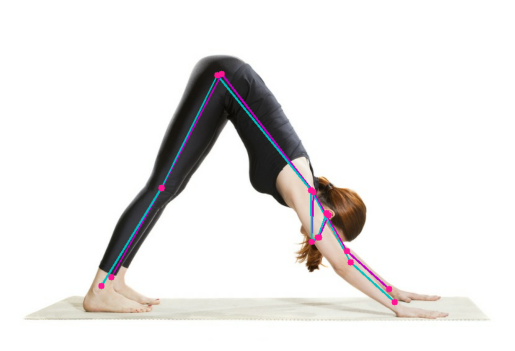

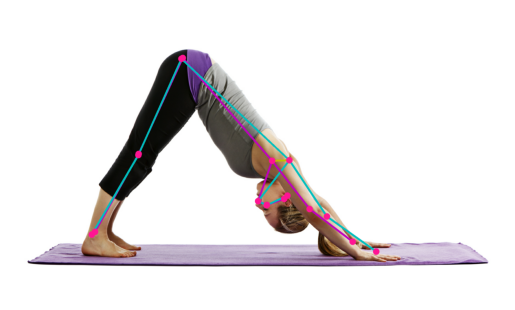

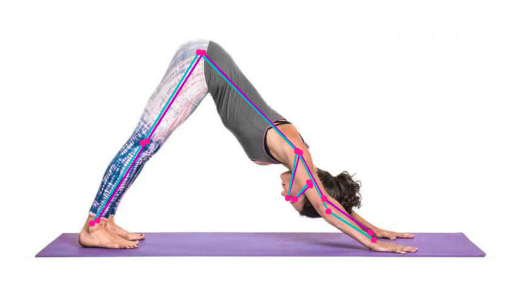

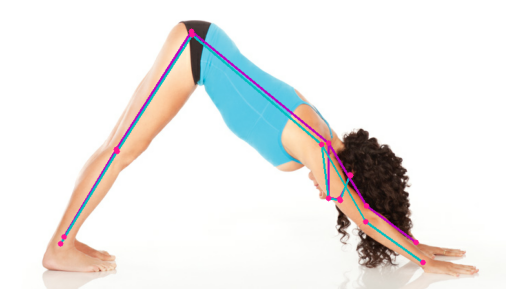

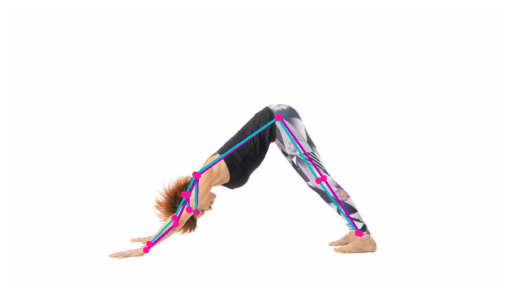

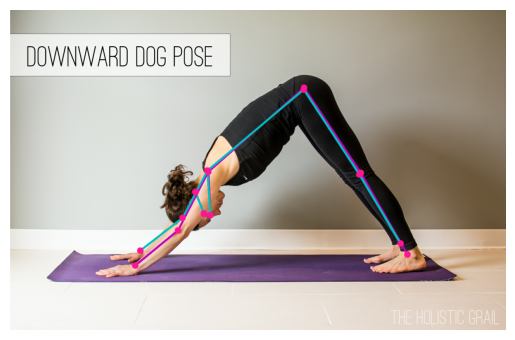

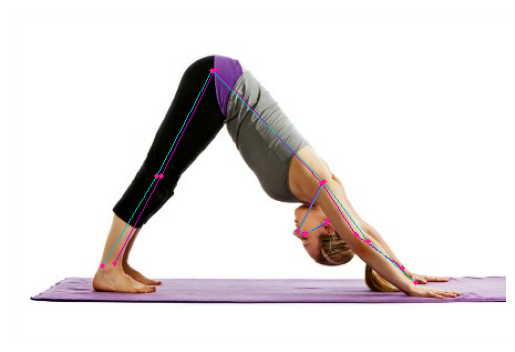

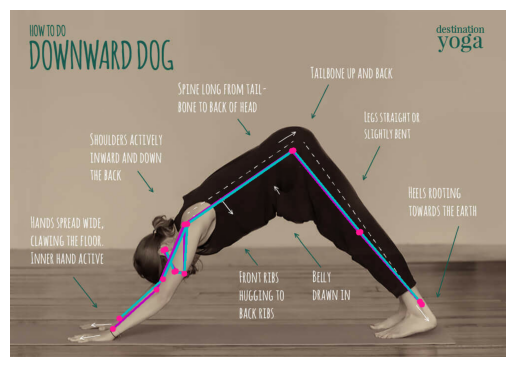

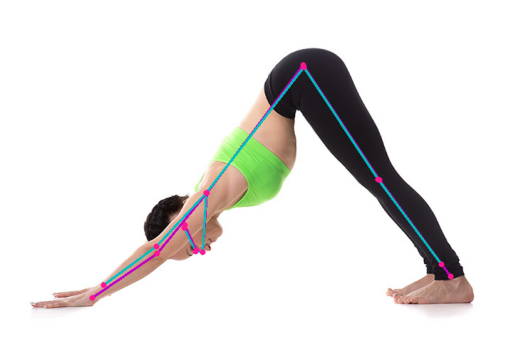

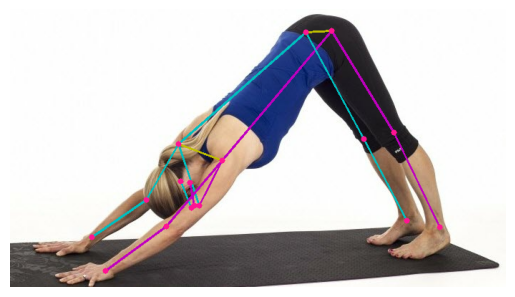

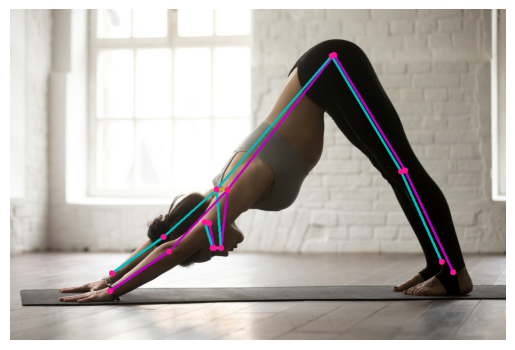

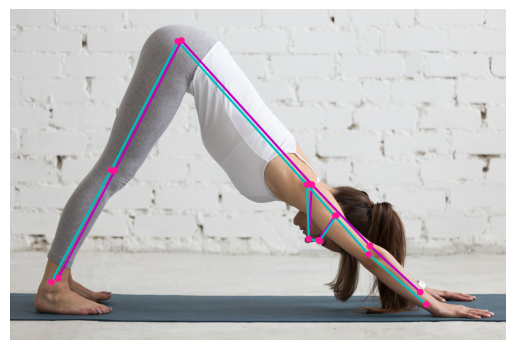

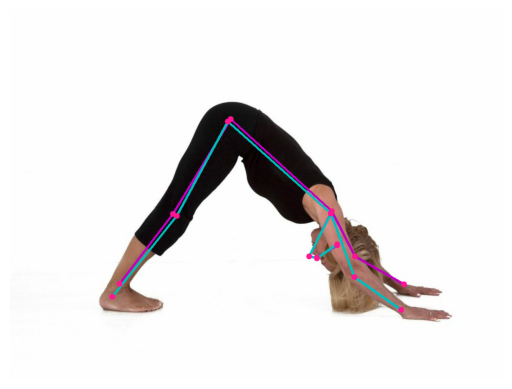

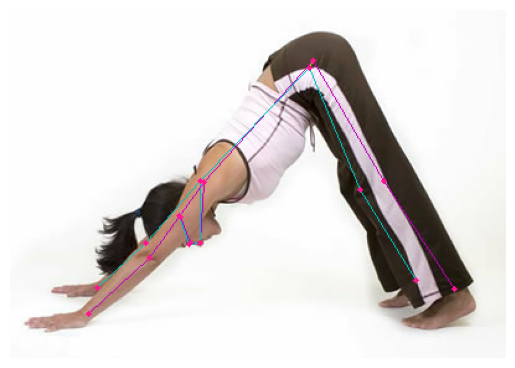

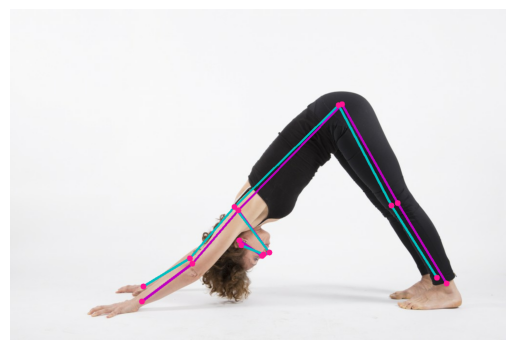

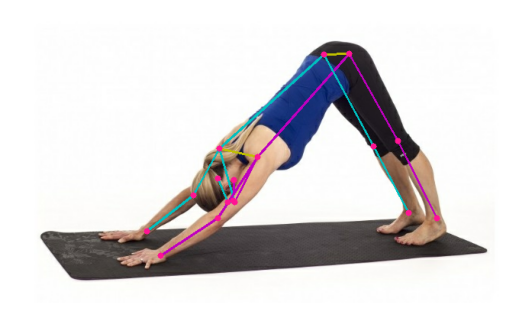

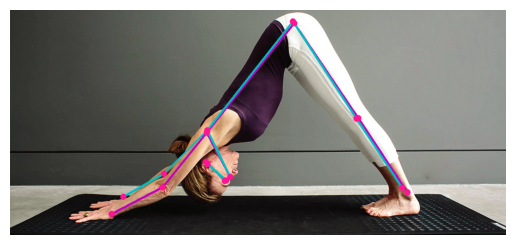

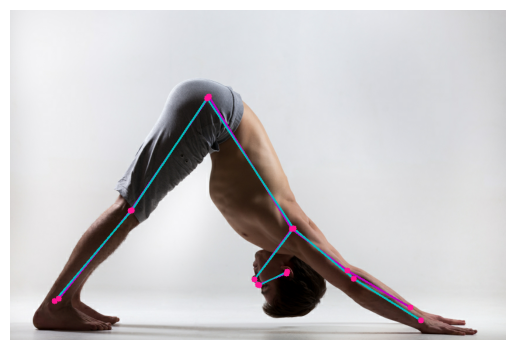

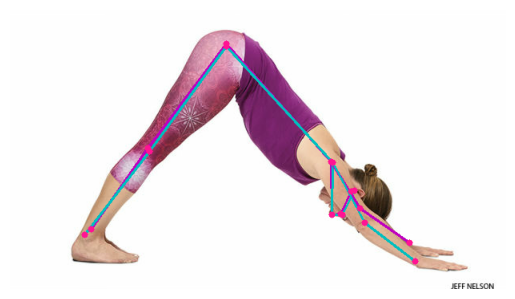

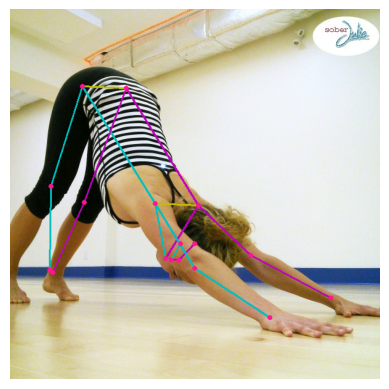

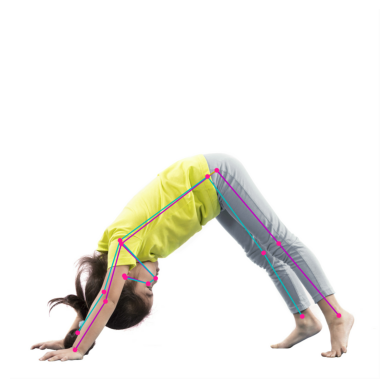

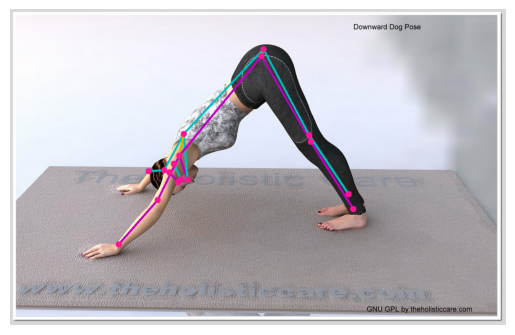

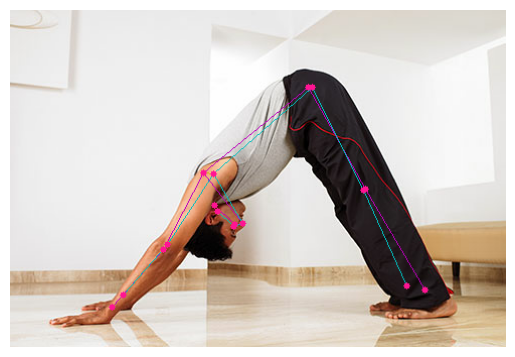

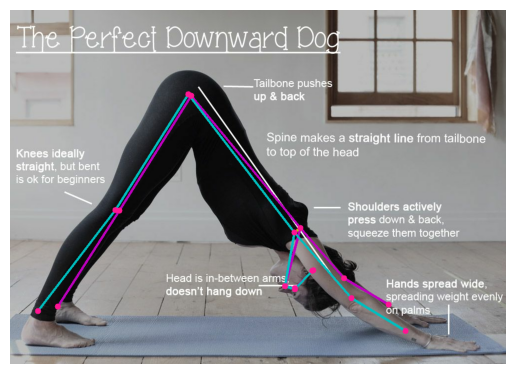

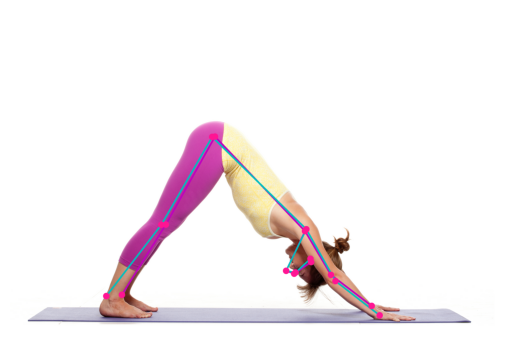

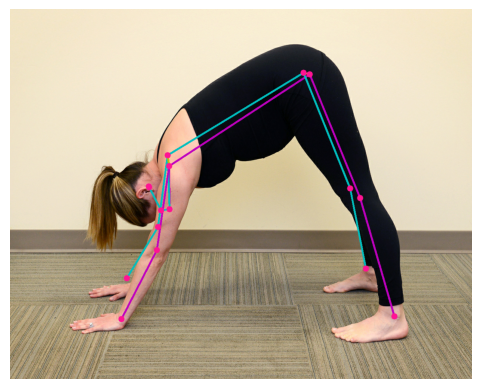

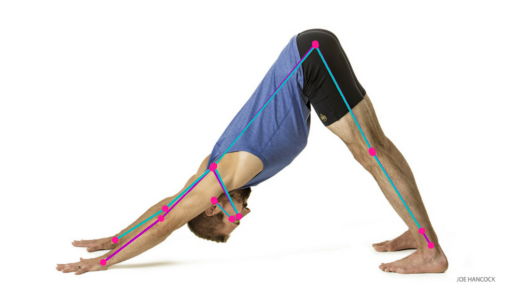

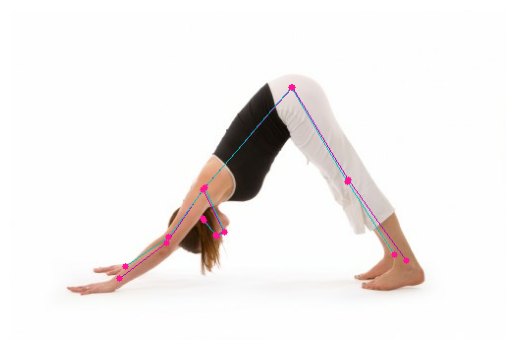

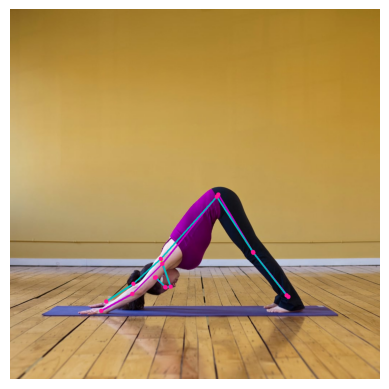

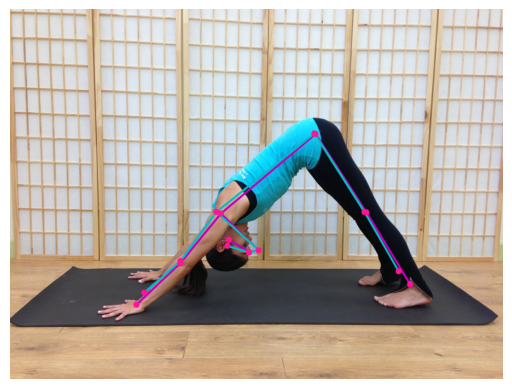

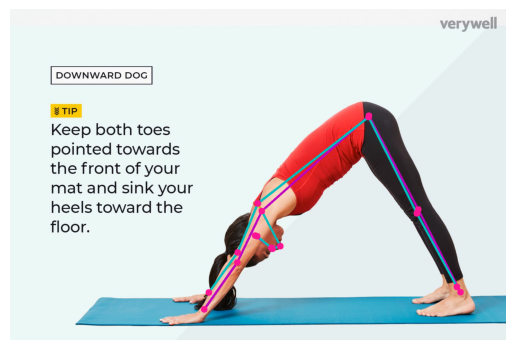

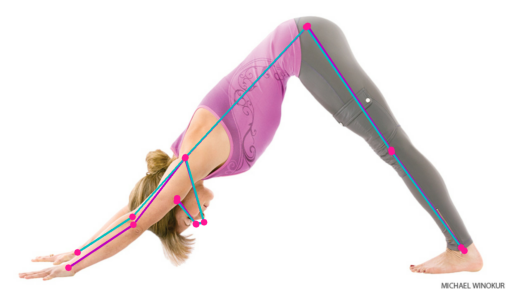

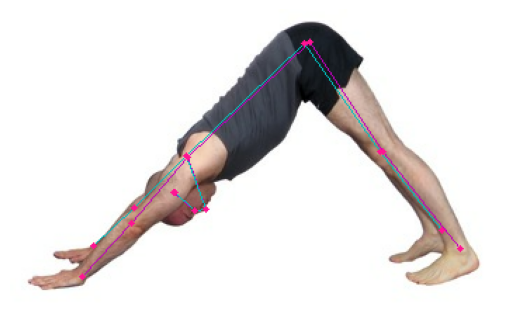

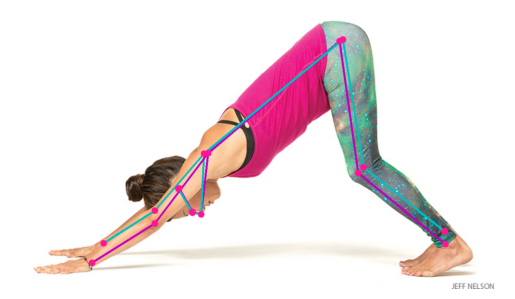

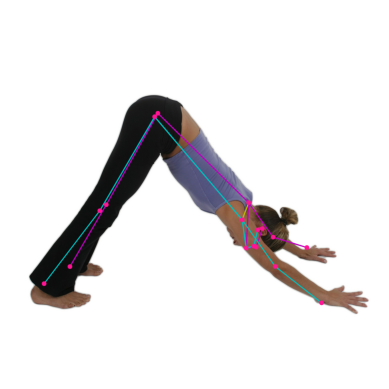

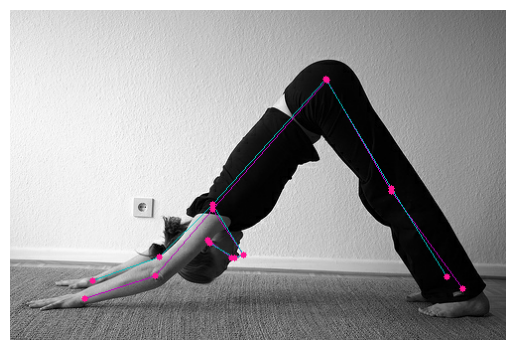

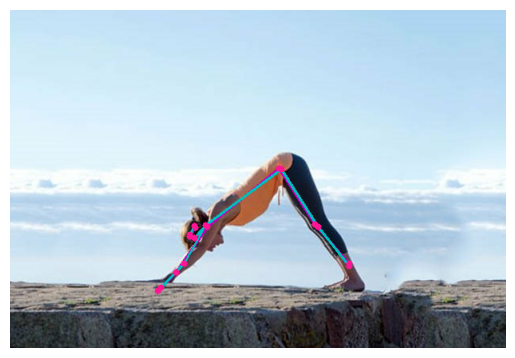

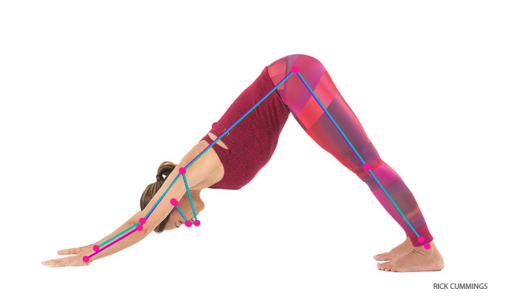

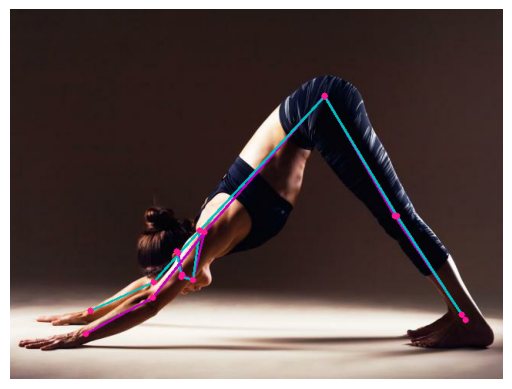

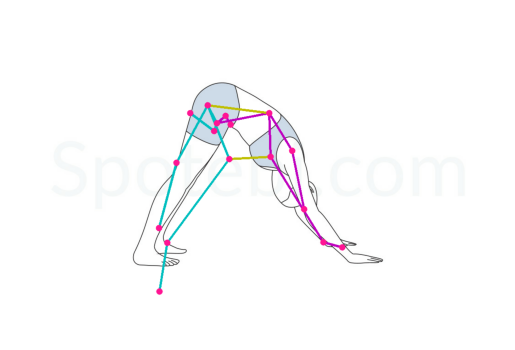

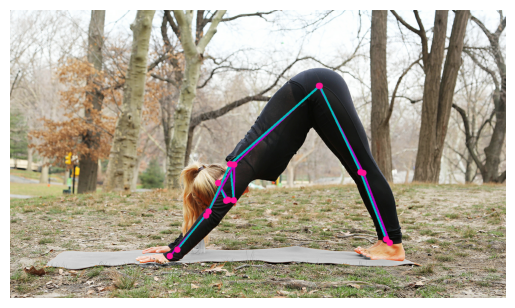

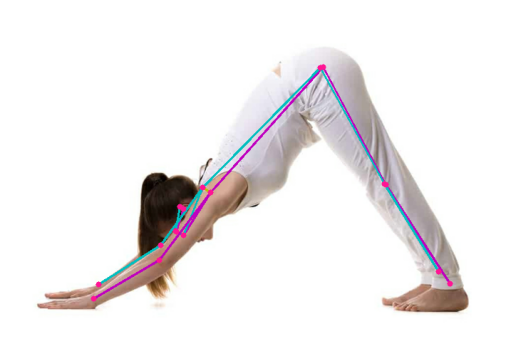

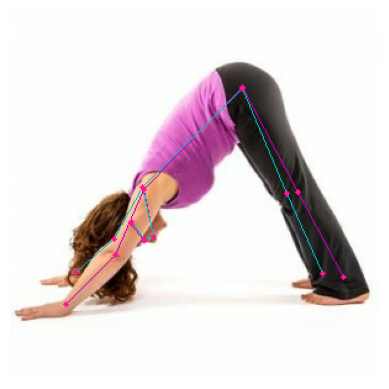

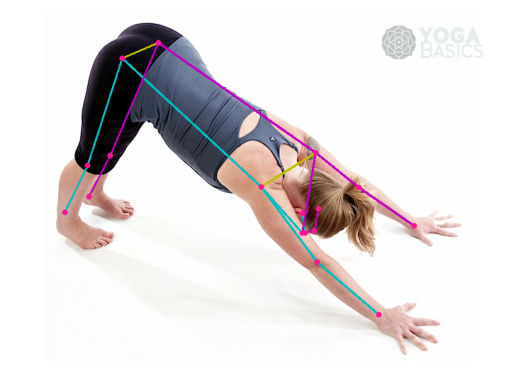

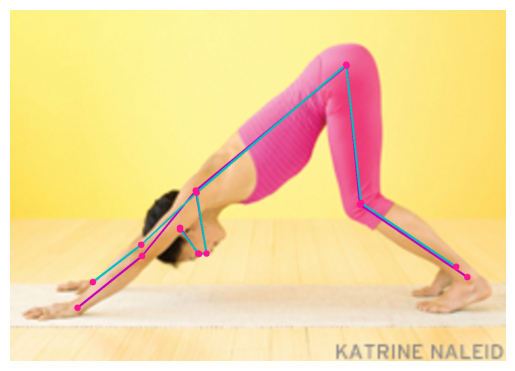

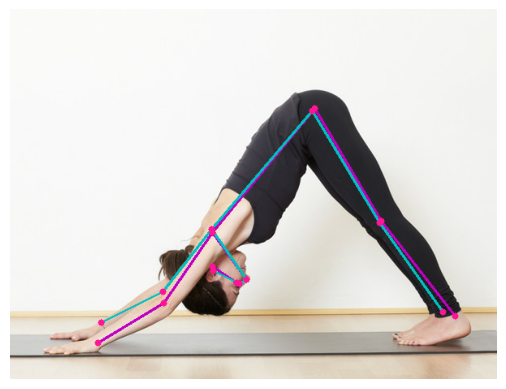

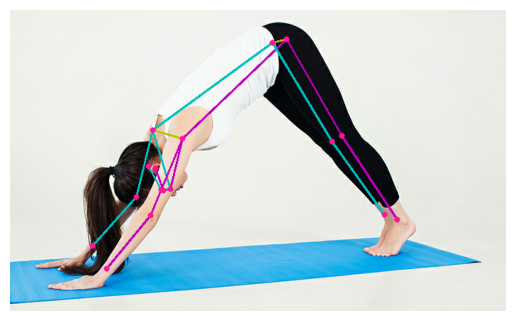

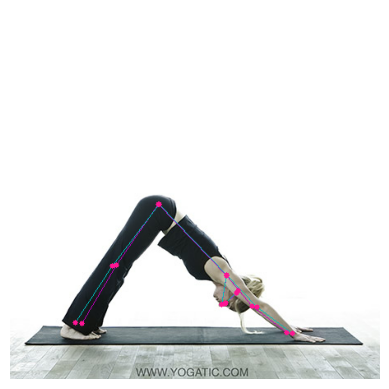

KeyboardInterrupt: 

In [11]:
os.makedirs("./output", exist_ok=True)
for i in range(len(raw_images)):
    show_and_save(i)
plt.close('all')